# Домашнее задание №1 - Метод К-ближайших соседей (K-neariest neighbors)

Сегодня мы с вами реализуем наш первый алгоритм машинного обучения, метод К-ближайших соседей. Мы попытаемся решить с помощью него задачи:
- бинарной классификации (то есть, только двум классам)
- многоклассовой классификации (то есть, нескольким классам)
- регрессии (когда зависимая переменная - натуральное число)

Так как методу необходим гиперпараметр (hyperparameter) - количество соседей, то нам нужно научиться подбирать этот параметр. Мы постараемся научиться пользовать numpy для векторизованных вычислений, а также посмотрим на несколько метрик, которые используются в задачах классификации и регрессии.

Перед выполнением задания:
- установите все необходимые библиотеки, запустив `pip install -r requirements.txt`

Если вы раньше не работали с numpy или позабыли его, то можно вспомнить здесь:  
http://cs231n.github.io/python-numpy-tutorial/

In [117]:
%load_ext autoreload
%autoreload 2
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
import pandas as pd
from IPython.display import display


from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from knn import KNNClassifier
from metrics import binary_classification_metrics, multiclass_accuracy, r_squared, mse, mae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

## Задание 1. KNN на датасете Fashion-MNIST (10 баллов)

В этом задании вам предстоит поработать с картинками одежды, среди которых можно выделить 10 классов. Данные уже загружены за вас: в переменной X лежат 70000 картинок размером 28 на 28 пикселей, вытянутые в вектор размерностью 784 (28 * 28). Так как данных довольно много, а наш KNN будет весьма медленный, то возьмем случайно 1000 наблюдений (в реальности в зависимости от вашей реализации можно будет взять больше, но если будет не зватать ОЗУ, то берите меньше).

In [73]:
X, y = fetch_openml(name="Fashion-MNIST", return_X_y=True, as_frame=False)

In [74]:
idx_to_stay = np.random.choice(np.arange(X.shape[0]), replace=False, size=1000)
X = X[idx_to_stay]
y = y[idx_to_stay]
y = y.astype(int)

Давайте посмотрим на какое-нибудь изображение из наших данных:

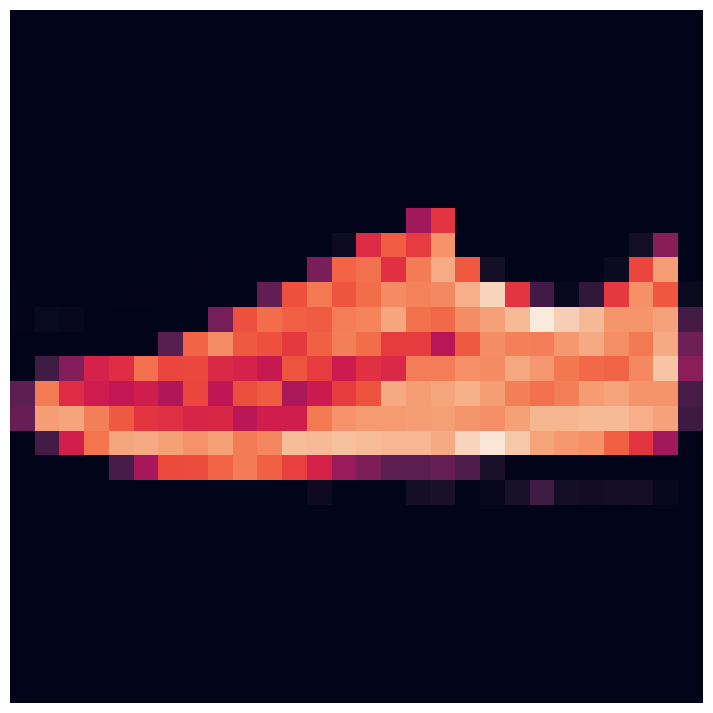

In [75]:
# возьмем случайную картинку и сделаем reshape
# 28, 28, 1 = H, W, C (число каналов, в данном случае 1)
image = X[np.random.choice(np.arange(X.shape[0]))].reshape(28, 28, 1)
plt.imshow(image)
plt.axis("off");

### 1.1. Посмотрим на все классы (0.5 баллов)

Возьмите по одной картинке каждого класса и изобразите их (например, сделайте subplots 5 на 2).

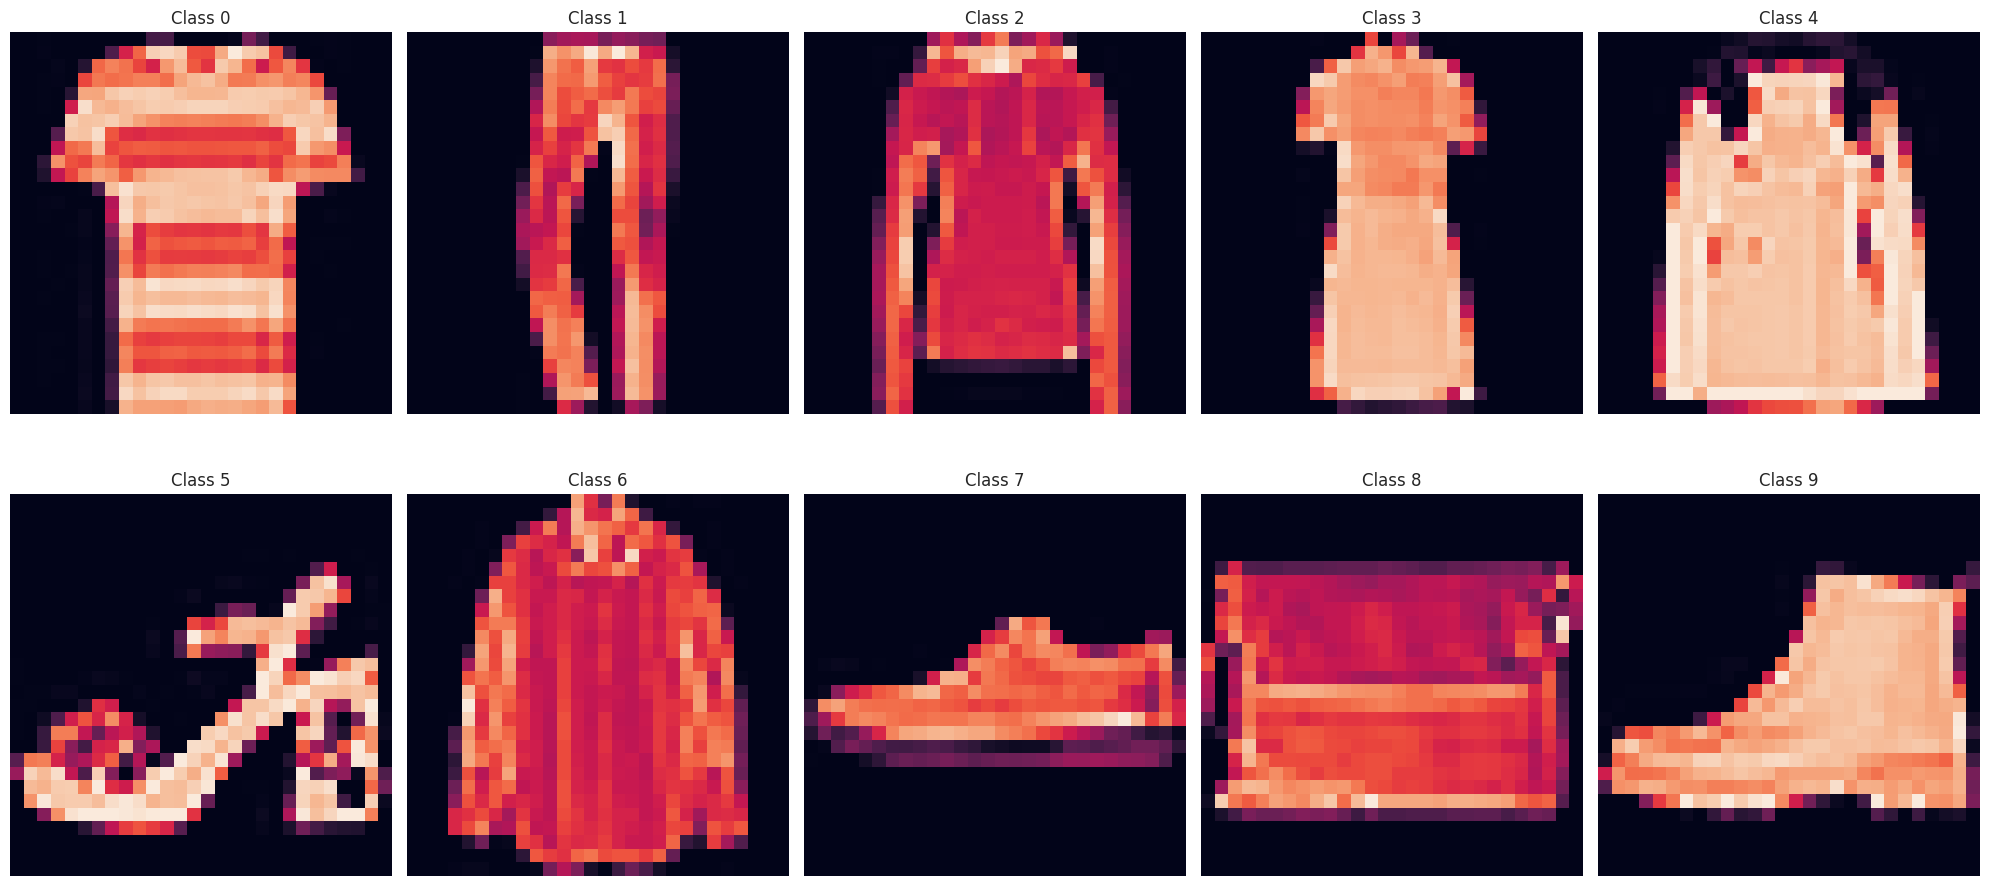

In [76]:
fig = plt.subplots(2, 5, figsize=(20, 10))

for class_label in range(10):
    indices = np.where(y == class_label)[0]
    random_index = np.random.choice(indices)
    image = X[random_index].reshape(28, 28, 1)
    plt.subplot(2, 5, class_label+1)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Class {class_label}")

plt.tight_layout()
plt.show()

### 1.2. Сделайте небольшой EDA (1 балл)

Посмотрите на баланс классов. В дальнейших домашках делайте EDA, когда считаете нужным, он нужен почти всегда, но оцениваться это уже не будет, если не будет указано иное. Делайте EDA, чтобы узнать что-то новое о данных!

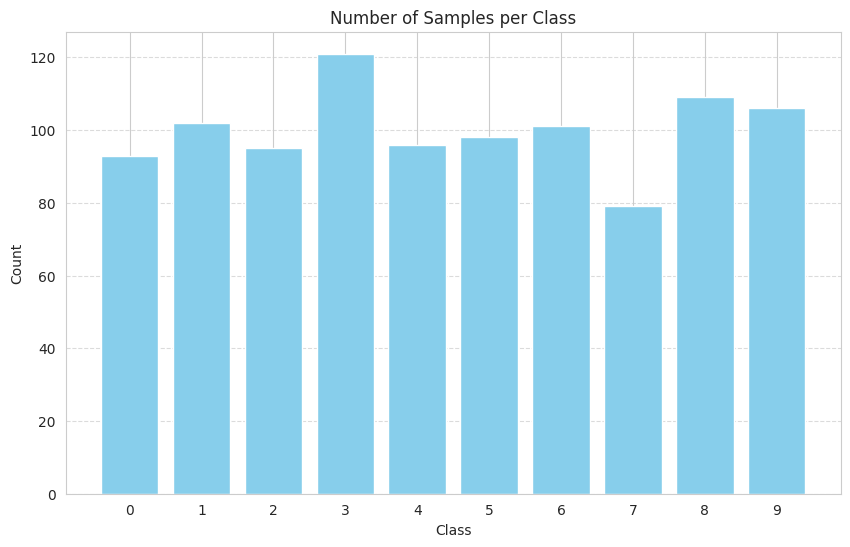

In [77]:
class_counts = np.bincount(y)

plt.figure(figsize=(10, 6))
plt.bar(np.arange(10), class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Samples per Class')
plt.xticks(np.arange(10))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 1.3. Разделите данные на train и test (0.5 баллов)

Разделите данные на тренировочную и тестовую выборки, размеры тестовой выборки выберите сами. Здесь вам может помочь функция `train_test_split`

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print("Размерность X_train:", X_train.shape)
print("Размерность X_test:", X_test.shape)
print("Размерность y_train:", y_train.shape)
print("Размерность y_test:", y_test.shape)

Размерность X_train: (670, 784)
Размерность X_test: (330, 784)
Размерность y_train: (670,)
Размерность y_test: (330,)


### 1.4. KNN для бинарной классификации (6 баллов)

Давайте возьмем для задачи бинарной классификации только объекты с метками классов 0 и 1.

In [79]:
# Создаем маску для объектов с метками классов 0 и 1
mask_train = np.logical_or(y_train == 0, y_train == 1)
mask_test = np.logical_or(y_test == 0, y_test == 1)

# Фильтруем тренировочные и тестовые данные согласно маске
binary_train_X = X_train[mask_train]
binary_train_y = y_train[mask_train]
binary_test_X = X_test[mask_test]
binary_test_y = y_test[mask_test]

print("Размерность binary_train_X:", binary_train_X.shape)
print("Размерность binary_train_y:", binary_train_y.shape)
print("Размерность binary_test_X:", binary_test_X.shape)
print("Размерность binary_test_y:", binary_test_y.shape)

Размерность binary_train_X: (135, 784)
Размерность binary_train_y: (135,)
Размерность binary_test_X: (60, 784)
Размерность binary_test_y: (60,)


И вот мы подготовили данные, но модели у нас пока что нет. В нескольких занятиях нашего курса вам придется самостоятельно реализовывать какие-то алгоритмы машинного обучения, а потом сравнивать их с готовыми библиотечными решениями. В остальных заданиях реализовывать алгоритмы будет не обязательно, но может быть полезно, поэтому часто это будут задания на дополнительные баллы, но главное не это, а понимание работы алгоритма после его реализации с нуля на простом numpy. Также это все потом можно оформить в виде репозитория ml_from_scratch и хвастаться перед друзьями.

In [80]:
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(binary_train_X, binary_train_y)

### Настало время писать код!

В KNN нам нужно для каждого тестового примера найти расстояния до всех точек обучающей выборки. Допустим у нас 1000 примеров в train'е и 100 в test'е, тогда в итоге мы бы хотели получить матрицу попарных расстояний (например, размерностью 100 на 1000). Это можно сделать несколькими способами, и кому-то наверняка, в голову приходит идея с двумя вложенными циклами (надеюсь, что не больше:). Так можно делать, то можно и эффективнее. Вообще, в реальном KNN используется структура данных [k-d-tree](https://ru.wikipedia.org/wiki/K-d-%D0%B4%D0%B5%D1%80%D0%B5%D0%B2%D0%BE), которая позволяет производить поиск за log(N), а не за N, как будем делать мы (по сути это такое расширение бинарного поиска на многомерное пространство).

Вам нужно будет последовательно реализовать методы `compute_distances_two_loops`, `compute_distances_one_loop` и `compute_distances_no_loops` класса `KNN` в файле `knn.py`.

Эти функции строят массив расстояний между всеми векторами в тестовом наборе и в тренировочном наборе.  
В результате они должны построить массив размера `(num_test, num_train)`, где координата `[i][j]` соотвествует расстоянию между i-м вектором в test (`test[i]`) и j-м вектором в train (`train[j]`).

**Обратите внимание** Для простоты реализации мы будем использовать в качестве расстояния меру L1 (ее еще называют [Manhattan distance](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B0%D0%BB%D0%BE%D0%B2)).

$d_{1}(\mathbf {p} ,\mathbf {q} )=\|\mathbf {p} -\mathbf {q} \|_{1}=\sum _{i=1}^{n}|p_{i}-q_{i}|$

В начале я буду иногда писать разные assert'ы, чтобы можно было проверить правильность реализации, в дальнейшем вам нужно будет их писать самим, если нужно будет проверять корректность каких-то вычислений.

In [81]:
# TODO: compute_distances_two_loops
dists = knn_classifier.compute_distances_two_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [82]:
# TODO: compute_distances_one_loop
dists = knn_classifier.compute_distances_one_loop(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

In [83]:
# TODO: compute_distances_no_loops
dists = knn_classifier.compute_distances_no_loops(binary_test_X)
assert np.isclose(dists[0, 100], np.sum(np.abs(binary_test_X[0] - binary_train_X[100])))

Проверим скорость работы реализованных методов

In [84]:
%timeit knn_classifier.compute_distances_two_loops(binary_test_X)
%timeit knn_classifier.compute_distances_one_loop(binary_test_X)
%timeit knn_classifier.compute_distances_no_loops(binary_test_X)

28.7 ms ± 1.11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
4.76 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.2 ms ± 786 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Реализуем метод для предсказания меток класса

In [85]:
# TODO: predict_labels_binary in knn.py
prediction = knn_classifier.predict_labels_binary(dists)
prediction == binary_test_y

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True])

### Метрика

Теперь нужно реализовать несколько метрик для бинарной классификации. Не забудьте подумать о численной нестабильности (деление на 0).

In [86]:
# TODO: binary_classification_metrics in metrics.py

In [87]:
precision, recall, f1, accuracy = binary_classification_metrics(prediction, binary_test_y)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')

Precision: 0.96875
Recall: 1.0
Accuracy: 0.9833333333333333
F1 score: 0.9841269841269841


Все ли хорошо с моделью? Можно проверить свою реализацию с функциями из библиотеки `sklearn`:

<img src="https://i.imgflip.com/406fu9.jpg" width="800" height="400">

In [88]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

precision = precision_score(binary_test_y, prediction)
recall = recall_score(binary_test_y, prediction)
accuracy = accuracy_score(binary_test_y, prediction)
f1 = f1_score(binary_test_y, prediction)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')
print(f'F1 score: {f1}')


Precision: 0.96875
Recall: 1.0
Accuracy: 0.9833333333333333
F1 score: 0.9841269841269841


### Подбор оптимального k

Чтобы подрбрать оптимальное значение параметра k можно сделать следующее: задать область допустимых значений k, например, `[1, 3, 5, 10]`. Дальше для каждого k обучить модель на тренировочных данных, сделать предсказания на тестовых и посчитать какую-нибудь метрику (метрику выберите сами исходя из задачи, но постарайтесь обосновать выбор). В конце нужно посмотреть на зависимость метрики на train'е и test'е от k и выбрать подходящее значение.

Реализуйте функцию `find_best_k` прямо в ноутбуке.

In [89]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    test_metrics = np.zeros(len(params))
    train_metrics = np.zeros(len(params))
    
    for i in range(len(params)):
        k = params[i]
        knn_classifier = KNNClassifier(k=k)
        knn_classifier.fit(X_train, y_train)
        
        dists_train = knn_classifier.compute_distances_no_loops(X_train)
        prediction_train = knn_classifier.predict_labels_binary(dists_train)
        
        dists_test = knn_classifier.compute_distances_no_loops(X_test)
        prediction_test = knn_classifier.predict_labels_binary(dists_test)
        
        train_metrics[i] = metric(y_train, prediction_train)
        test_metrics[i] = metric(y_test, prediction_test)

    return train_metrics, test_metrics

In [90]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(binary_train_X, binary_train_y, binary_test_X, binary_test_y, params, accuracy_score)

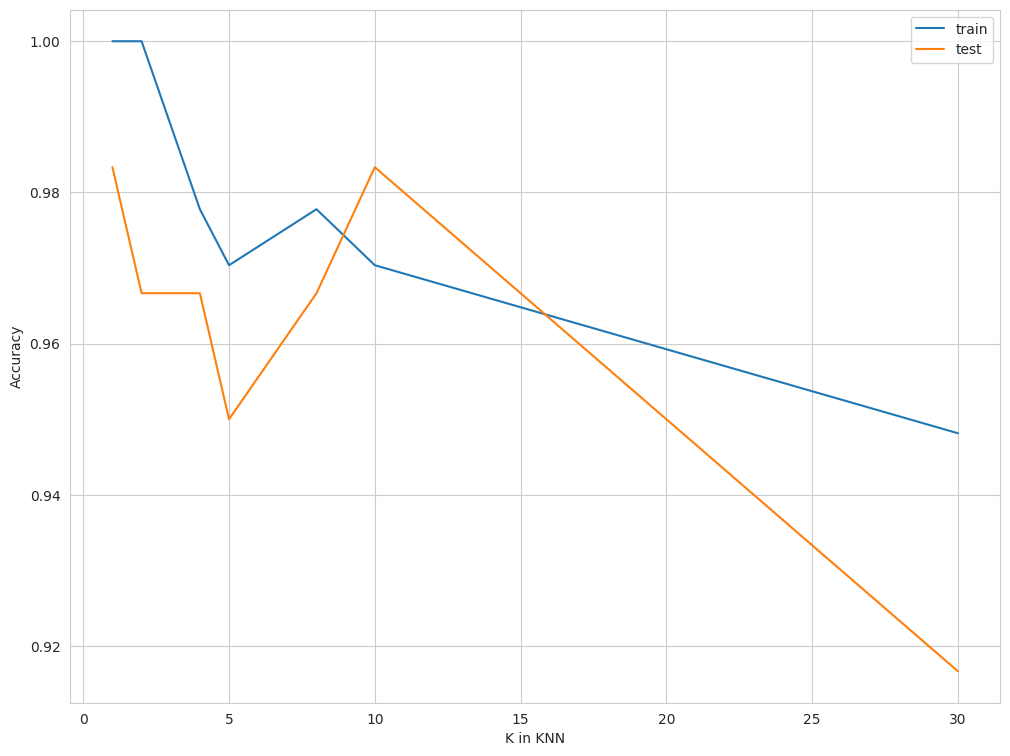

In [91]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuracy");

На самом деле, это не самый лучший способ подбирать гиперпараметры, но способы получше мы рассмотрим в следующий раз, а пока что выберите оптимальное значение k, сделайте предсказания и посмотрите, насколько хорошо ваша модель предсказывает каждый из классов.

### 1.5. Многоклассоввая классификация (2 балла)

Теперь нужно научиться предсказывать все 10 классов. Для этого в начале напишем соответствующий метод у нашего классификатора.

In [92]:
# TODO: predict_labels_multiclass in knn.py
knn_classifier = KNNClassifier(k=1)
knn_classifier.fit(X_train, y_train)
predictions = knn_classifier.predict(X_test)
predictions == y_test

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True,  True,
       False,  True, False, False,  True,  True, False, False,  True,
        True, False, False,  True, False,  True,  True,  True,  True,
        True, False, False, False,  True,  True, False,  True,  True,
       False,  True,  True, False, False, False,  True,  True, False,
        True,  True,  True, False,  True, False,  True,  True,  True,
       False,  True, False,  True, False, False,  True,  True,  True,
        True,  True,  True,  True, False,  True, False, False, False,
        True,  True,  True, False,  True,  True, False,  True,  True,
       False, False, False,  True, False,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,

Осталось реализовать метрику качества для многоклассовой классификации, для этого реализуйте функцию `multiclass_accuracy` в `metrics.py`.

In [93]:
# TODO: multiclass_accuracy in metrics.py
multiclass_accuracy(predictions, y_test)

0.7212121212121212

Снова выберите оптимальное значение K как мы делали для бинарной классификации.

In [94]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, accuracy_score)

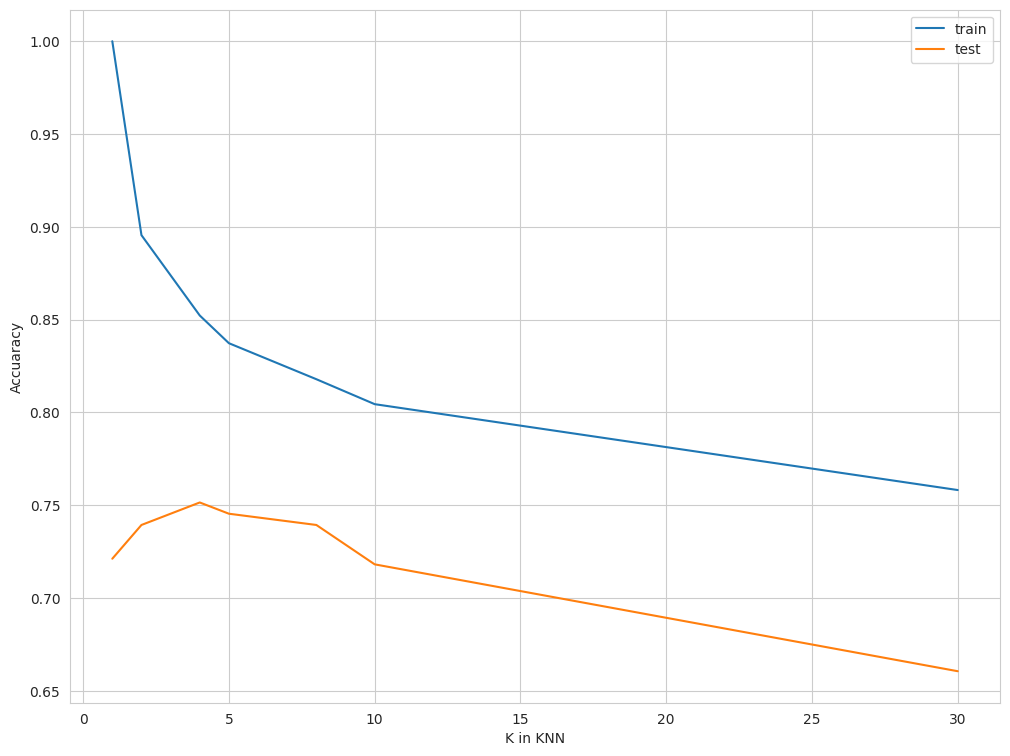

In [95]:
plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("Accuaracy");

## Задание 2. KNN на датасете diabetes (10 баллов)

Теперь попробуем применить KNN к задаче регрессии. Будем работать с [данными](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) о диабете. В этом задании будем использовать класс `KNeighborsRegressor` из библиотеки `sklearn`. Загрузим необходимые библиотеки:

In [96]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

In [97]:
X, y = load_diabetes(as_frame=True, return_X_y=True, scaled = False)

In [98]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0


### 2.1. EDA (2 обязательных балла + 2 доп. балла за Pipeline)

Сделайте EDA, предобработайте данные так, как считаете нужным, нужна ли в данном случае стандартизация и почему? Не забудте, что если вы стандартизуете данные, то нужно считать среднее и сдандартное отклонение на тренировочной части и с помощью них трансформировать и train, и test (**если не поняли это предложение, то обязательно разберитесь**).

**Дополнительно**:
Попробуйте разобраться с [`Pipeline`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), чтобы можно было создать класс, который сразу проводит стандартизацию и обучает модель (или делает предсказание). Пайплайны очень удобны, когда нужно применять различные методы предобработки данных (в том числе и к разным столбцам), а также они позволяют правильно интегрировать предобработку данных в различные классы для поиска наилучших гиперпараметров модели (например, `GridSearchCV`).

In [99]:
from sklearn.pipeline import Pipeline

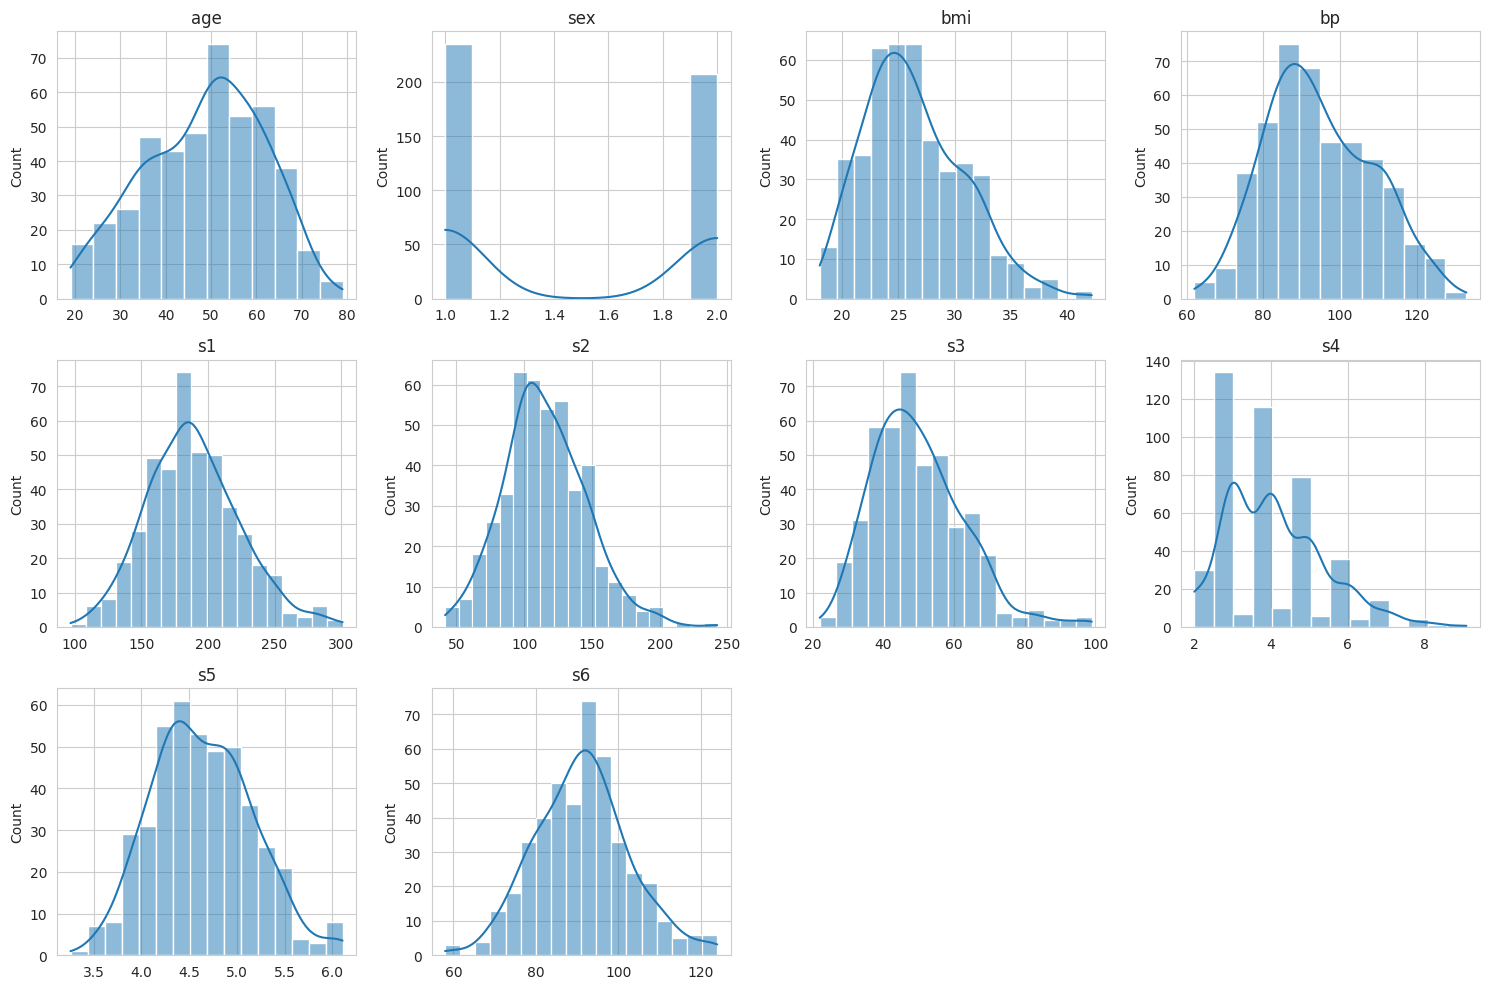

In [100]:
# Оценим распредление переменных-предикторов
plt.figure(figsize=(15, 10))
for i, col in enumerate(X.columns):
    plt.subplot(3, 4, i + 1)
    ax = sns.histplot(X[col], kde = True)
    ax.set(xlabel=None)
    plt.title(col)
plt.tight_layout()
plt.show()

In [101]:
# Оценим наличие NA
X.isna().sum()

age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64

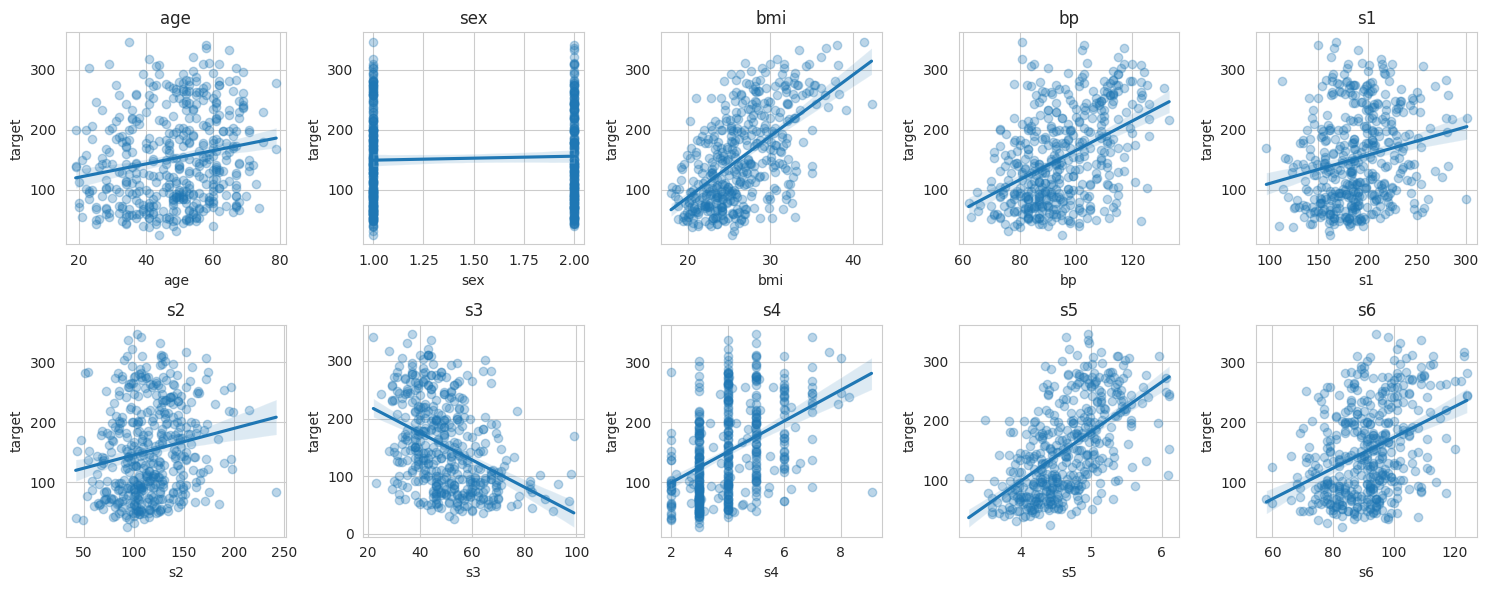

In [102]:
# Посмотрим на зивисимость таргетной переменной от предикторов
df = pd.concat([X, y], axis=1)
plt.figure(figsize=(15, 6))
for i, col in enumerate(X.columns):
    plt.subplot(2, 5, i + 1)
    sns.regplot(data=df, x=col, y="target",  scatter_kws={'alpha':0.3})
    plt.title(col)
plt.tight_layout()
plt.show()

### 2.2. Регрессионная модель (1 балл)

Создайте модель `KNeighborsRegressor`, обучите ее на треноровочных данных и сделайте предсказания.

In [103]:
# Разделяем данные на тестовые и тренировочные
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("Размерность X_train:", X_train.shape)
print("Размерность X_test:", X_test.shape)
print("Размерность y_train:", y_train.shape)
print("Размерность y_test:", y_test.shape)

Размерность X_train: (296, 10)
Размерность X_test: (146, 10)
Размерность y_train: (296,)
Размерность y_test: (146,)


In [138]:
# Реализация пайплайна со стандартизацией
cat_cols = ['sex']
num_cols = ['age', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelEncoder)
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])
knn_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("knn", KNeighborsRegressor(n_neighbors=8, n_jobs=8))
])


In [139]:
knn_pipeline.fit(X_train, y_train)
y_pred_regress = knn_pipeline.predict(X_test)

In [140]:
df = pd.concat([X, y], axis=1)
df = pd.concat([df, pd.Series(y_pred_regress, name = 'y_pred')], axis=1)

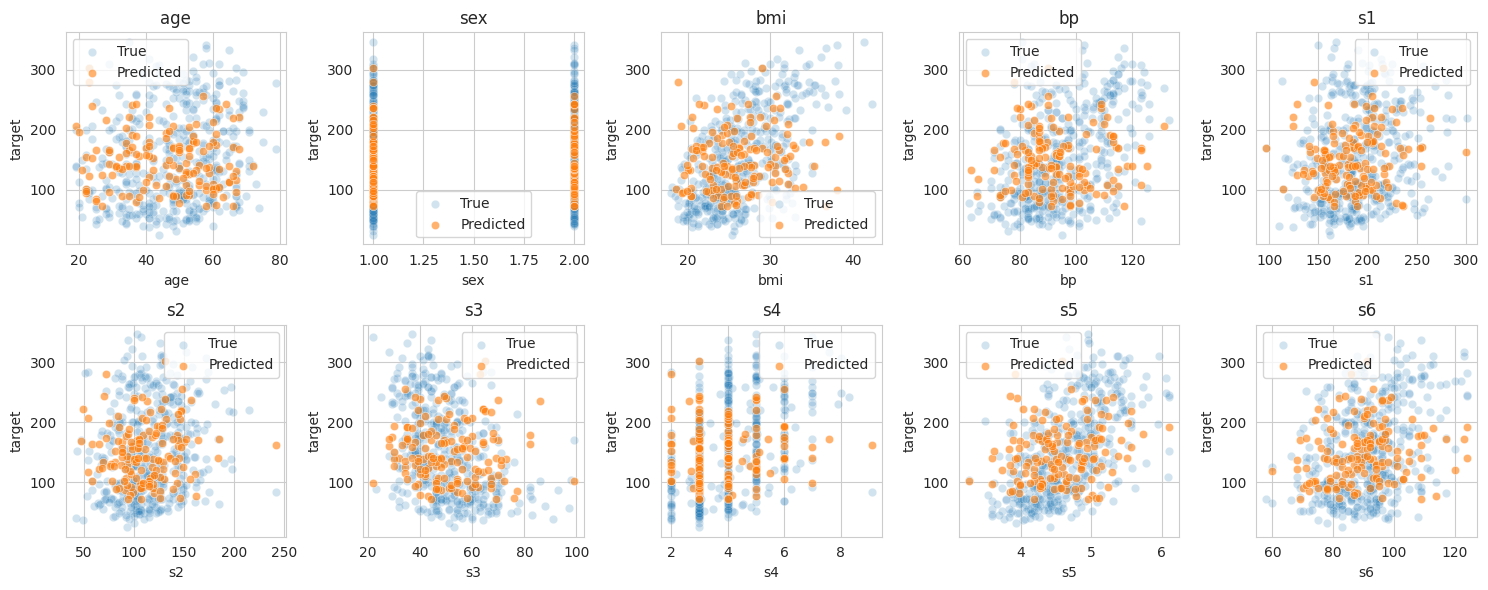

In [141]:
plt.figure(figsize=(15, 6))
for i, col in enumerate(X.columns):
    plt.subplot(2, 5, i + 1)
    sns.scatterplot(data=df, x=col, y='target', alpha = 0.2, label="True")
    sns.scatterplot(data=df, x=col, y='y_pred', alpha = 0.6, label="Predicted")
    plt.title(col)
plt.tight_layout()
plt.show()


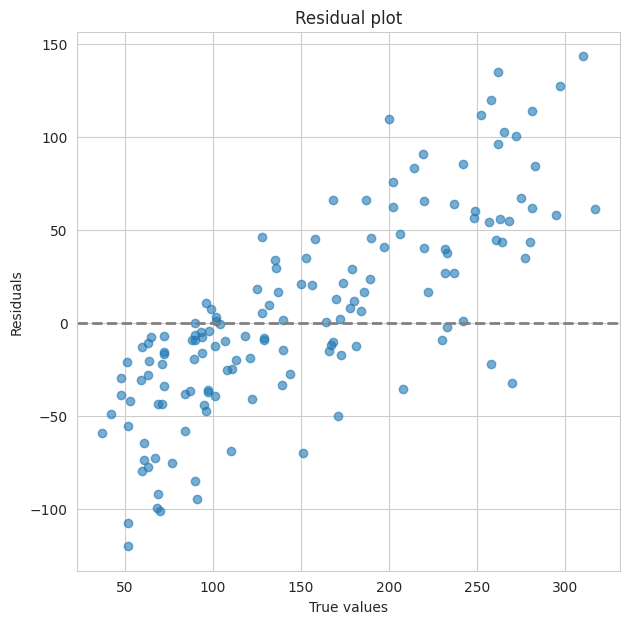

In [142]:
plt.figure(figsize=(7, 7))
residuals = y_test - y_pred_regress
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--', lw=2)  
plt.title('Residual plot')
plt.xlabel('True values')
plt.ylabel('Residuals')
plt.show()

### 2.3. Метрики регресии (3 балла)

Реализуйте метрики $R^2$, MSE и  MAE в `metrics.py`. Примените их для оценки качества полученной модели. Все ли хорошо?

Напомню, что:

$R^2 = 1 - \frac{\sum_i^n{(y_i - \hat{y_i})^2}}{\sum_i^n{(y_i - \overline{y})^2}}$

$MSE = \frac{1}{n}\sum_i^n{(y_i - \hat{y_i})^2}$

$MAE = \frac{1}{n}\sum_i^n{|y_i - \hat{y_i}|}$

In [143]:
# TODO: r_squared, mse, mae in metrics.py
print(f"R squared: {r_squared(y_test, y_pred_regress)}")
print(f"MSE: {mse(y_test, y_pred_regress)}")
print(f"MAE: {mae(y_test, y_pred_regress)}")

R squared: 0.50090862472155
MSE: 2872.400577910959
MAE: 41.89640410958904


In [144]:
# Metrics from sklearn
print(f"R squared: {r2_score(y_test, y_pred_regress)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_regress)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_regress)}")

R squared: 0.50090862472155
MSE: 2872.400577910959
MAE: 41.89640410958904


Судя по метрике R squared, полученная модель достаточно хорошо предсказывает значения таргетной перменной и объясняет примерно половину наблюдаемой дисперсии. 

### 2.4. Подбор оптимального числа соседей (2 балла)

Мы почти дошли до конца. Теперь осталось при помощи реализованных нами метрик выбрать лучшее количество соседей для нашей модели.

!!! Обратите внимание на то, что значат наши метрики, для некоторых хорошо, когда они уменьшаются, для других наоборот.

In [ ]:
from metrics import r_squared, mse, mae

In [145]:
def find_best_k(X_train, y_train, X_test, y_test, params, metric):
    """
    Choose the best k for KKNClassifier
    Arguments:
    X_train, np array (num_train_samples, num_features) - train data
    y_train, np array (num_train_samples) - train labels
    X_test, np array (num_test_samples, num_features) - test data
    y_test, np array (num_test_samples) - test labels
    params, list of hyperparameters for KNN, here it is list of k values
    metric, function for metric calculation
    Returns:
    train_metrics the list of metric values on train data set for each k in params
    test_metrics the list of metric values on test data set for each k in params
    """
    test_metrics = np.zeros(len(params))
    train_metrics = np.zeros(len(params))
    
    for i in range(len(params)):
        k = params[i]
        knn_pipeline = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("knn", KNeighborsRegressor(n_neighbors=k, n_jobs=8))
        ])
        knn_pipeline.fit(X_train, y_train)
        
        prediction_train = knn_pipeline.predict(X_train)
        prediction_test = knn_pipeline.predict(X_test)
        
        train_metrics[i] = metric(y_train, prediction_train)
        test_metrics[i] = metric(y_test, prediction_test)

    return train_metrics, test_metrics

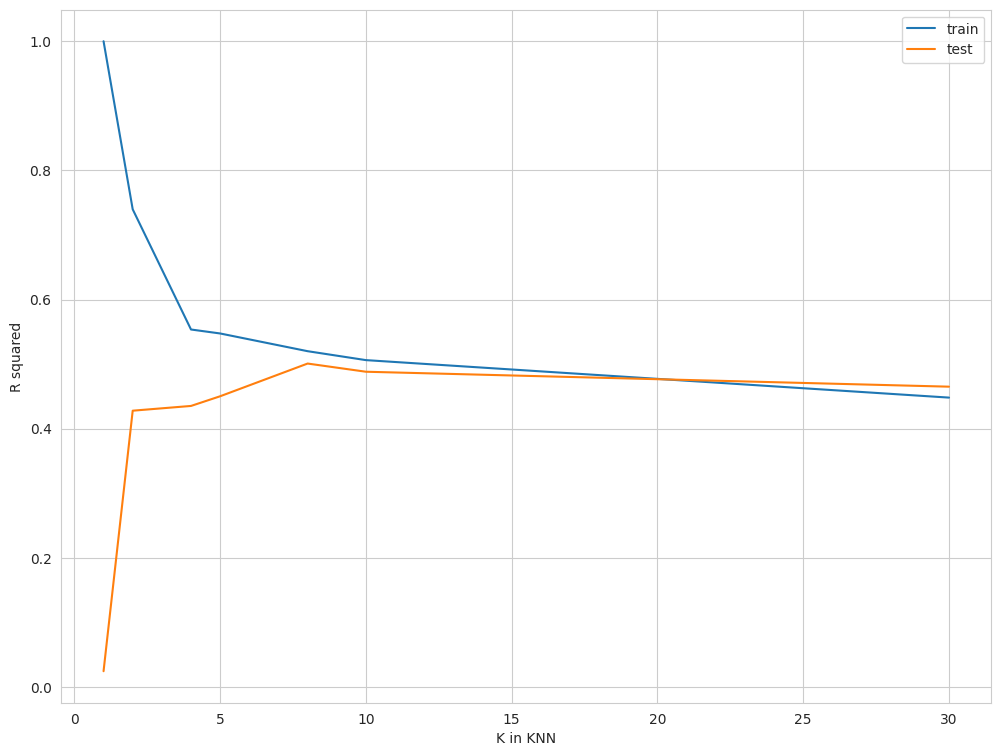

In [146]:
params = [1, 2, 4, 5, 8, 10, 30]
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, r_squared)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("R squared");

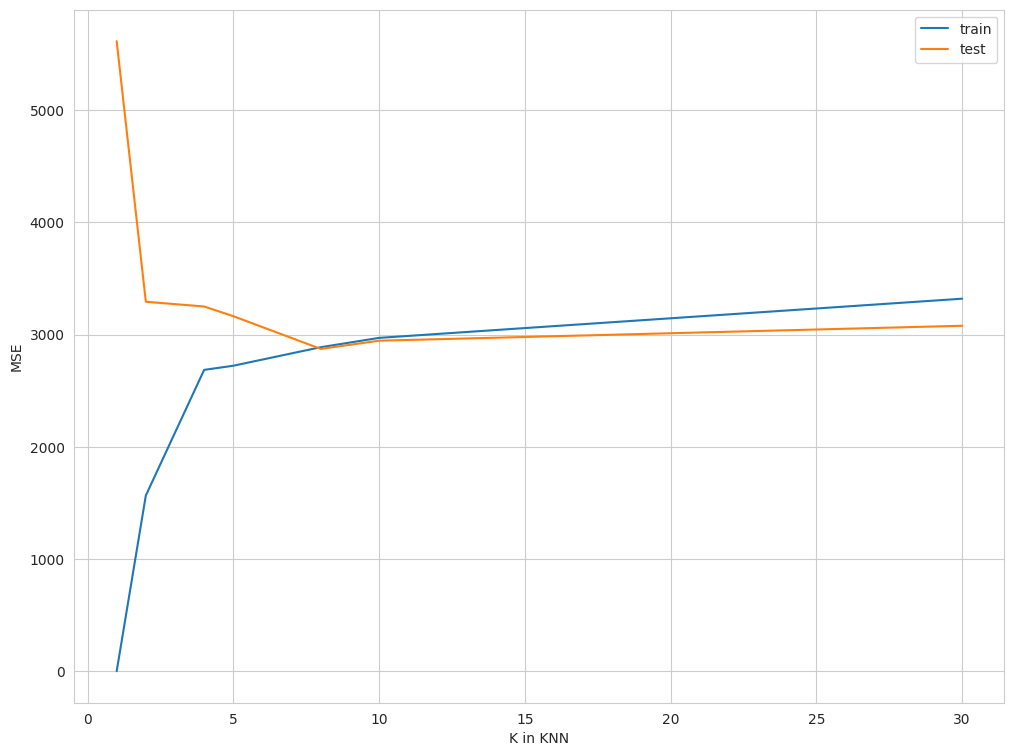

In [147]:
train_metrics, test_metrics = find_best_k(X_train, y_train, X_test, y_test, params, mse)

plt.plot(params, train_metrics, label="train")
plt.plot(params, test_metrics, label="test")
plt.legend()
plt.xlabel("K in KNN")
plt.ylabel("MSE");

Для тестовой выборки метрика R squared больше всего, а MSE меньше всего при значении **k = 8**, значит 8 - это оптимальное количество соседей.

### 3. Социализация (0.5 доп. балла)

Так как у нас теперь большая группа, то было бы здорово всем познакомиться получше (так как выпускной не за горами). Соберитесь с одногруппниками в зуме, познакомьтесь, а сюда прикрепите скриншот с камерами всех участников.

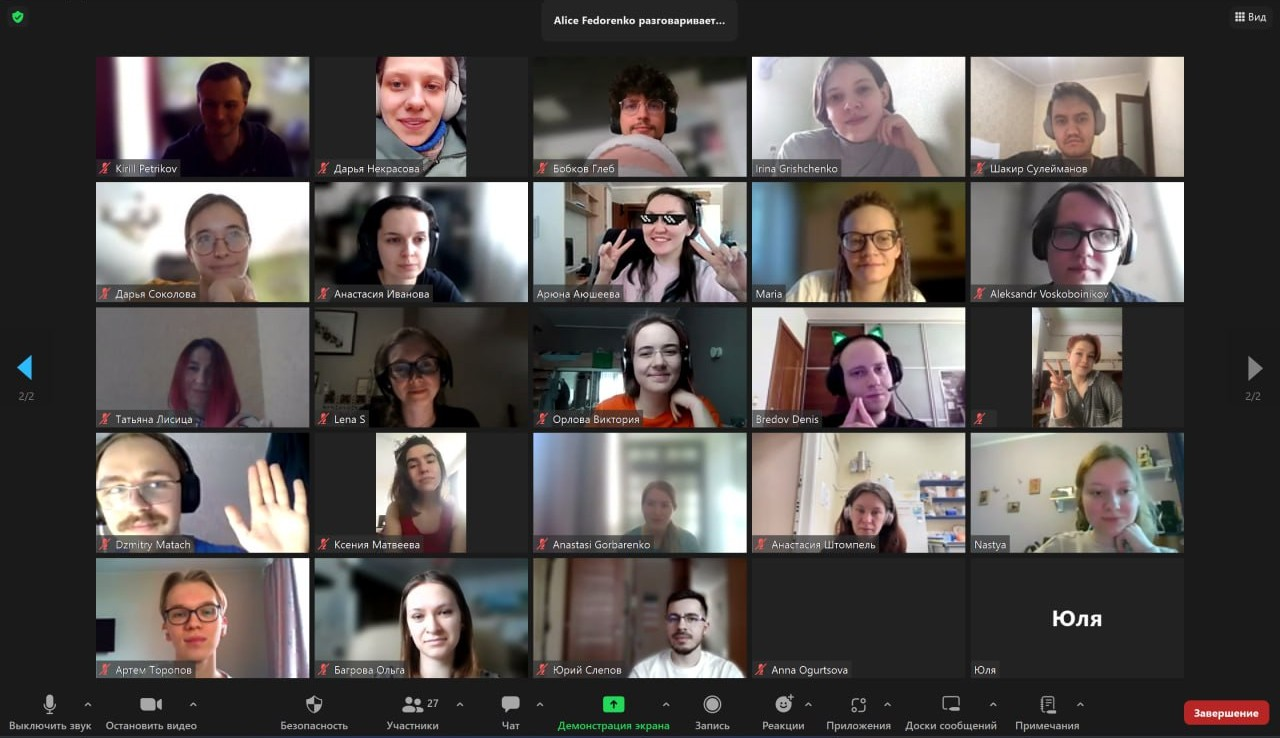

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

По началу было легко потеряться в новой терминологии и сложно концептуально понять, что именно нужно сделать и для чего. В целом, понравилось писать самому функции-аналоги функций из sklearn, потому что так было гораздо больше мотивации разобраться что и откуда берется. Но для первой недели после каникул довольно жесткое вхождение :)